In [361]:
# Import necessary libs
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [362]:
# Read in data file
df_all = pd.read_csv('../Processed Data/AllPlayerDataProcessed.csv')
df_gk = pd.read_csv('../Processed Data/GKDataProcessed.csv')
df_bk = pd.read_csv('../Processed Data/BKDataProcessed.csv')
df_md = pd.read_csv('../Processed Data/MDDataProcessed.csv')
df_fwd = pd.read_csv('../Processed Data/FWDDataProcessed.csv')

In [363]:
# Split data into training set and testing set
# First split Overall as a target value
target = df_all.Overall
y = np.array(target, dtype = np.float32)
df_model = df_all.drop(['Overall', 'Index', 'Position'], axis = 1)
X = np.array(df_model, dtype = np.float32)

# Then split data into test and train
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)
print(y_train.shape)

(14517,)


In [364]:
# Here we define the regression model class as follows
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(37, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

regressor = RegressionNN()
# Below we initialize optimizer and loss function
optimizer = optim.Adam(regressor.parameters(), lr=1e-3)
criterion = nn.MSELoss(size_average=False)

C:\Users\lhc\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [365]:
# Define iterations and batch size
n_iteration = 200
batch_size = 256
n_train_data = X_train.shape[0]
n_batch = int(np.ceil(n_train_data/batch_size))

# Convert training data and testing data to tensor format
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_train_tensor = torch.from_numpy(y_train).float().reshape(14517, 1)
y_val_tensor = torch.from_numpy(y_val).float().reshape(1815, 1)

In [366]:
## start 
train_loss_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)

for i in range(n_iteration):
    ave_train_loss = 0
    # Train with batch GD
    for j in range(n_batch):
        batch_start_index = j*batch_size
        X_batch = X_train_tensor[batch_start_index:batch_start_index+batch_size]
        y_batch = y_train_tensor[batch_start_index:batch_start_index+batch_size]

        # training
        y_out = regressor(X_batch)
        loss = criterion(y_out, y_batch)
        
        # update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    y_val_out = regressor(X_val_tensor)

In [367]:
# Testing
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().reshape(1815, 1)
y_test_out = regressor(X_test_tensor)
print(type(y_test))

#Finding the r2 score and root mean squared error
from sklearn.metrics import r2_score, mean_squared_error
print('r2 score: '+str(r2_score(y_test, y_test_out.detach().numpy())))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test, y_test_out.detach().numpy()))))

<class 'numpy.ndarray'>
r2 score: 0.98358759888038
RMSE : 0.8900187


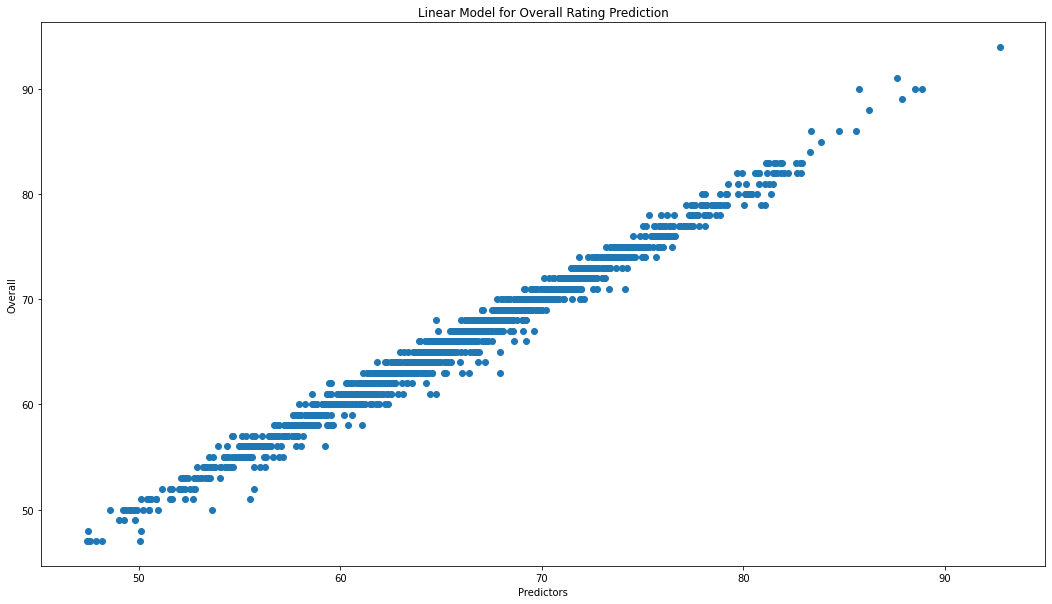

In [368]:
# Plot the results
plt.figure(figsize=(18,10))
plt.scatter(y_test_out.detach().numpy(), y_test)
plt.xlabel("Predictors")
plt.ylabel('Overall')
plt.title("Linear Model for Overall Rating Prediction")
plt.show()